# Assignment 2: Machine Learning Project
## Project 1: Classify Images of Colon Cancer
### By Julian Schmidt-Heron (ID: s4002485) and Swayam Mayankkumar Patel (ID: s3994439)

### 1.1 Data Exploration and Understanding

#### Class Imbalance Identification

In [1]:
#First import the nesesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# And also set consistent plot style
sns.set(style="whitegrid")

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Load the dataset CSVs
# Define paths
main_data_path = "Image_classification_data/data_labels_mainData.csv"
extra_data_path = "Image_classification_data/data_labels_extraData.csv"

# Load CSVs into pandas DataFrames
main_df = pd.read_csv(main_data_path)
extra_df = pd.read_csv(extra_data_path)

# Have a quick preview of the datasets
print("Main Data:")
print(main_df.head())
print("\nExtra Data:")
print(extra_df.head())

Main Data:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

Extra Data:
   InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


##### Task 1

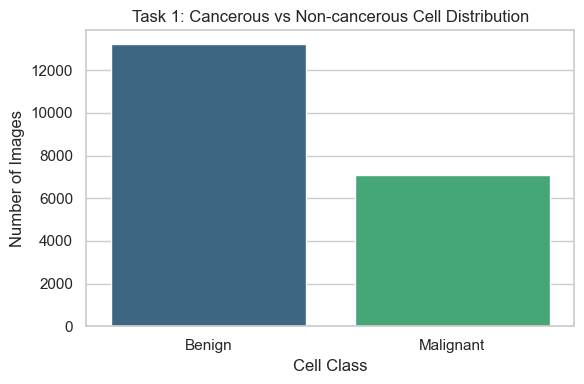

Task 1 - Cancerous Class Distribution:
isCancerous
Benign       13211
Malignant     7069
Name: count, dtype: int64


In [3]:
# ForTask 1, we will have a look at the Class Distribution of Cancerous vs Non-cancerous Cells

# Task 1 is "isCancerous", available in both main and extra data
# We'll concatenate the two datasets for a full view
combined_df_task1 = pd.concat([main_df[['isCancerous']], extra_df[['isCancerous']]])

# Count the number of samples per class
task1_counts = combined_df_task1['isCancerous'].value_counts().sort_index()

# Map labels for better visualization
task1_labels = {0: 'Benign', 1: 'Malignant'}

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=[task1_labels[i] for i in task1_counts.index], y=task1_counts.values, palette="viridis")
plt.title('Task 1: Cancerous vs Non-cancerous Cell Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Cell Class')
plt.tight_layout()
plt.show()

# Display actual numbers
print("Task 1 - Cancerous Class Distribution:")
print(task1_counts.rename(index=task1_labels))

In [4]:
# Calculate class imbalance ratio for Task 1
benign = task1_counts[0]
malignant = task1_counts[1]
imbalance_ratio = round(max(benign, malignant) / min(benign, malignant), 2)

# Printing out the values with their names
print(f"Task 1 Imbalance Ratio (isCancerous):: {imbalance_ratio}")


Task 1 Imbalance Ratio (isCancerous):: 1.87


•For our task 1 data, we can see that there is a class inbalance of 1.87, meaning that Benign instances appear 1.87 times more often than Malignant instances. We can see that Benign appears 13211 times, and Malignant appears 7069 times, with Benign being almost twice as prevelent as Malignant. This imbalance can bias the model toward the majority class during training, so we will later apply balancing techniques such as class weighting or augmentation to help the model learn to classify both classes more effectively.


##### Task 1

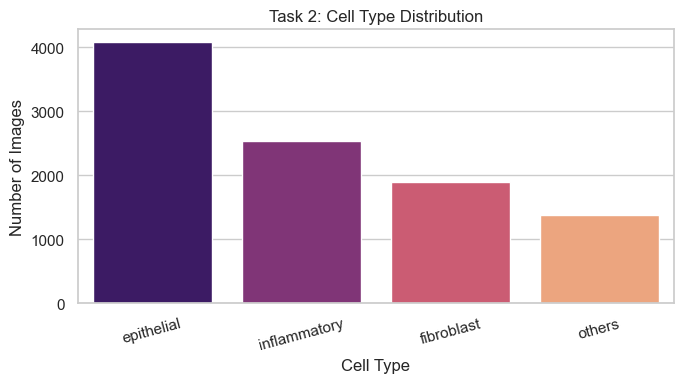

Task 2 - Cell Type Distribution:
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64


In [5]:
# ForTask 2, we will have a look at the Class Distribution of Cell Type  (only in main_df)

# Task 2 is "cellTypeName", only available in the main data (first 60 patients)
task2_counts = main_df['cellTypeName'].value_counts()

# Plot
plt.figure(figsize=(7, 4))
sns.barplot(x=task2_counts.index, y=task2_counts.values, palette="magma")
plt.title('Task 2: Cell Type Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Cell Type')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Display actual numbers
print("Task 2 - Cell Type Distribution:")
print(task2_counts)

In [6]:
# Calculate class imbalance ratio for Task 2 (Cell Type)
# Count the occurrences of each class (cell type) in Task 2
task2_counts = main_df['cellTypeName'].value_counts()

# Get counts for each class
fibroblast = task2_counts.get('fibroblast', 0)
inflammatory = task2_counts.get('inflammatory', 0)
epithelial = task2_counts.get('epithelial', 0)
others = task2_counts.get('others', 0)

# Calculate imbalance ratio (max/min)
task2_imbalance_ratio = round(max(fibroblast, inflammatory, epithelial, others) / min(fibroblast, inflammatory, epithelial, others), 2)

# Print the imbalance ratio
print(f"Task 2 Imbalance Ratio (Cell Type): {task2_imbalance_ratio}")


Task 2 Imbalance Ratio (Cell Type): 2.94


•For our task 2 data (Cell Type Classification), we can see that there is a class imbalance ratio of 2.94, meaning that Epithelial instances appear 2.94 times more often than Others. Specifically, Epithelial appears 4,079 times, Inflammatory appears 2,543 times, Fibroblast appears 1,888 times and Others appears 1,386 times. This imbalance can bias the model toward the majority class (Epithelial), so we will apply techniques such as class weighting or augmentation to balance the training process.

##### EDA 

To better understand the dataset before building any machine learning models, we first explored the structure and patterns within the data through visual and statistical analysis. Below are several key insights gathered during this process.

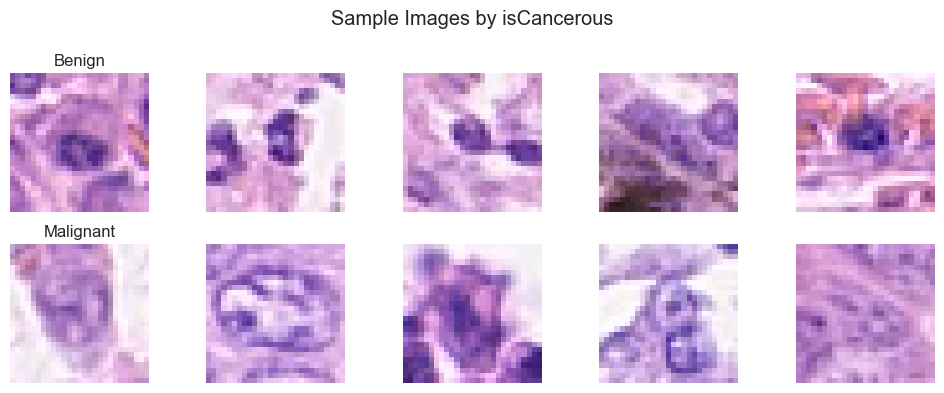

In [7]:
import cv2
import numpy as np

# Path to your image folder
image_folder = 'Image_classification_data/patch_images'  
# Everything else remains the same
def load_image(img_name, target_size=(27, 27)):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img

# Visualize samples by class (Task 1: isCancerous)
def plot_samples_by_class(df, label_col='isCancerous', class_labels={0: 'Benign', 1: 'Malignant'}, samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2, 4))
    
    for idx, (class_val, label) in enumerate(class_labels.items()):
        class_df = df[df[label_col] == class_val]
        selected_rows = class_df.sample(n=samples_per_class, random_state=42)
        
        for i, (_, row) in enumerate(selected_rows.iterrows()):
            img = load_image(row['ImageName'])
            if img is None:
                continue
            plt.subplot(2, samples_per_class, idx * samples_per_class + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label if i == 0 else "")
    
    plt.suptitle(f'Sample Images by {label_col}')
    plt.tight_layout()
    plt.show()

# Run for Task 1
plot_samples_by_class(main_df, label_col='isCancerous', class_labels={0: 'Benign', 1: 'Malignant'})


#### Sample Images by Class (isCancerous)

• To begin our image exploration, we selected random samples from both the Benign and Malignant classes. By visualizing these examples, we can start to develop an intuition about what features might distinguish the two classes. This helps us later when choosing appropriate models and preprocessing techniques. The visual differences between the two groups, though subtle, may guide the model during learning.

In [8]:
dims = []
for img_name in main_df['ImageName']:
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        dims.append(img.shape)

# Show unique image shapes and their counts
pd.Series(dims).value_counts()

(27, 27, 3)    9896
Name: count, dtype: int64

#### Image Dimension Consistency

• We checked the shape and color channels of all the images to make sure they are consistent. All images were found to be 27x27 in size and had 3 color channels (RGB), which is exactly what we need for our image classification task. This confirms that the dataset is clean and ready for use with CNN-based models.


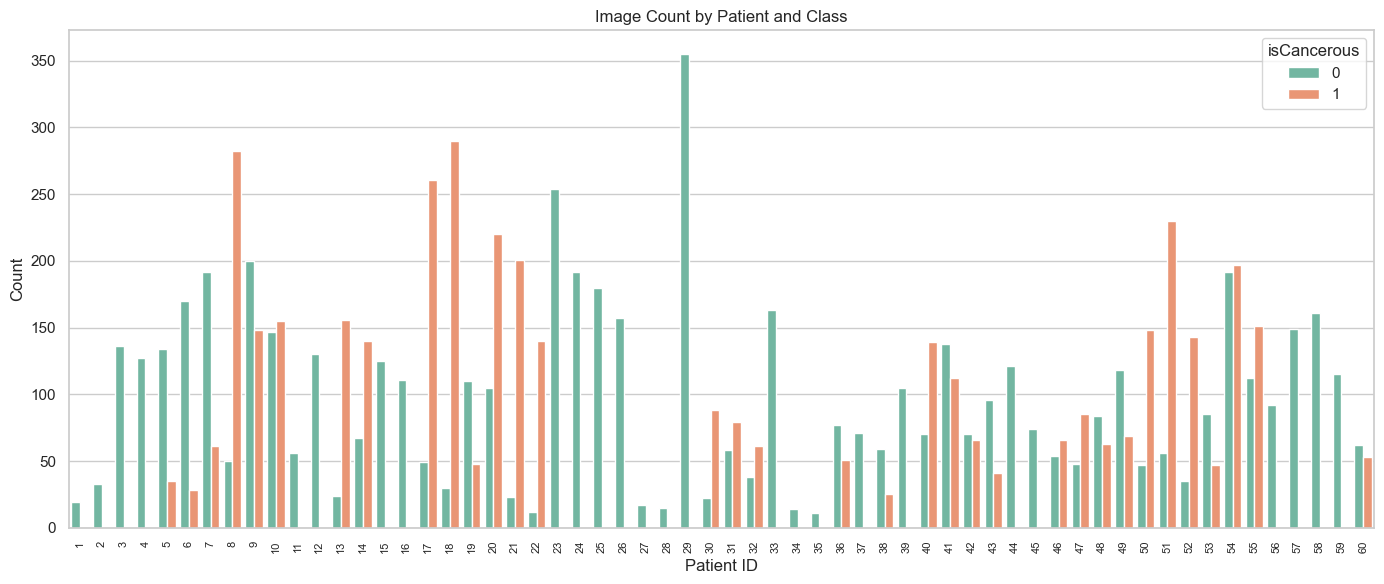

In [9]:
plt.figure(figsize=(14, 6))  # make the plot wider
sns.countplot(data=main_df, x="patientID", hue="isCancerous", palette="Set2")
plt.title("Image Count by Patient and Class")
plt.xlabel("Patient ID")
plt.ylabel("Count")
plt.xticks(rotation=90, fontsize=8)  # rotate and reduce font size
plt.tight_layout()
plt.show()

#### Image Count by Patient and Class

• Next, we explored how many cancerous and non-cancerous images came from each patient. This helped us identify if any individual patients contributed disproportionately to one class. From the plot, we observed that some patients have a much higher number of images, which is important to consider when we later split the data to avoid patient-specific bias in the model.


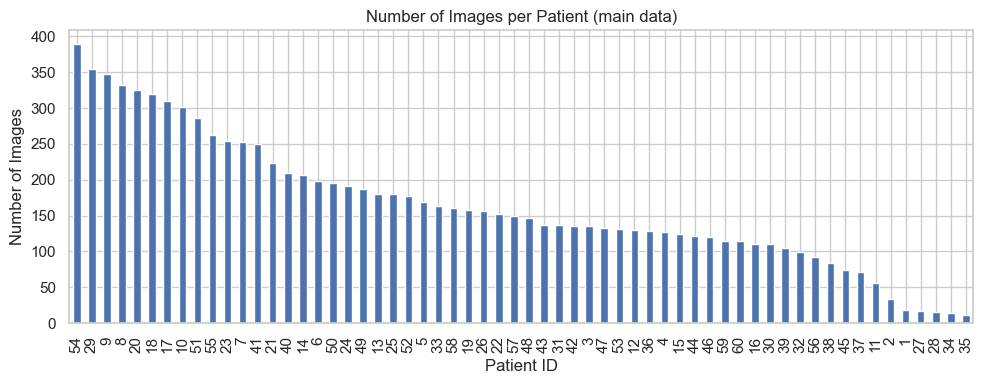

In [10]:
main_df['patientID'].value_counts().plot(kind='bar', figsize=(10, 4))
plt.title("Number of Images per Patient (main data)")
plt.xlabel("Patient ID")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

#### Total Image Count per Patient

• We also plotted the total number of images per patient to see how the data is distributed. A few patients contributed significantly more images than others, which could impact training if not handled carefully. This will influence how we perform patient-based splitting for fair training and evaluation.


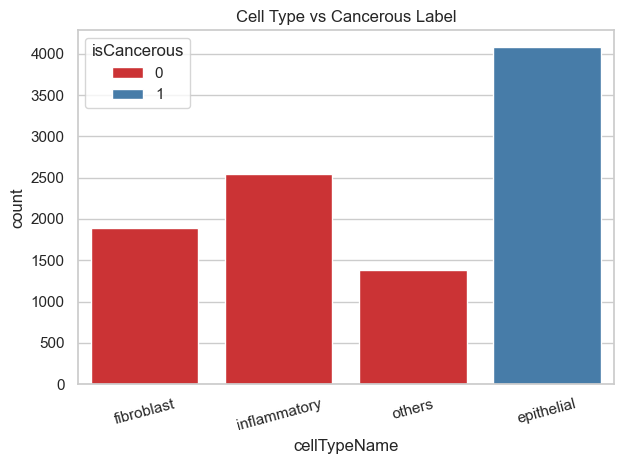

In [11]:
sns.countplot(data=main_df, x="cellTypeName", hue="isCancerous", palette="Set1")
plt.title("Cell Type vs Cancerous Label")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#### Cell Type vs Cancer Label Distribution

• We then looked at how the different cell types relate to the cancerous label. We found that some cell types, like epithelial cells, were much more common in cancerous samples. This could affect how the model learns to associate certain visual patterns with the malignant label. Understanding this relationship will help us handle class bias and improve generalization.


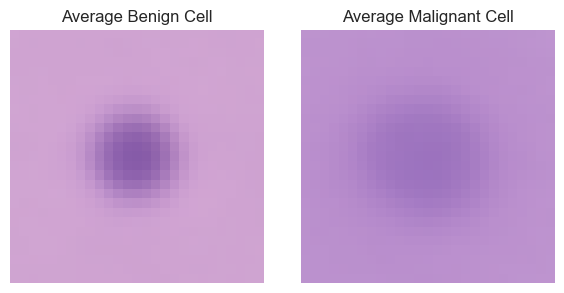

In [12]:
def compute_average_image(df_subset):
    imgs = []
    for name in df_subset['ImageName']:
        img = load_image(name)
        if img is not None:
            imgs.append(img)
    return np.mean(imgs, axis=0)

# Compute average for full class data
benign_avg = compute_average_image(main_df[main_df['isCancerous'] == 0])
malignant_avg = compute_average_image(main_df[main_df['isCancerous'] == 1])

# Plot average images
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(benign_avg)
ax[0].set_title("Average Benign Cell")
ax[1].imshow(malignant_avg)
ax[1].set_title("Average Malignant Cell")
for a in ax: a.axis('off')
plt.tight_layout()
plt.show()

#### Average Cell Image Per Class

• To get a high-level view of the general appearance of each class, we generated an average image for benign and malignant cells. This was done by averaging pixel values across all images in each group. The average benign cell appears to have a sharper central shape, while the malignant cell is more diffuse. This kind of visualization helps us understand the core structure that the model may use during learning.